This tutorial is a modified version of [Stanford's CS231n](http://cs231n.stanford.edu/) course materials.

In this tutorial, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [ ]:
# This downloads the CIFAR-10 dataset if it doesn't already exist.

!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz


--2022-11-24 13:57:55--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  94.0MB/s    in 1.7s    

2022-11-24 13:57:58 (94.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import platform
from six.moves import cPickle as pickle


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
#@title Data utils


def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


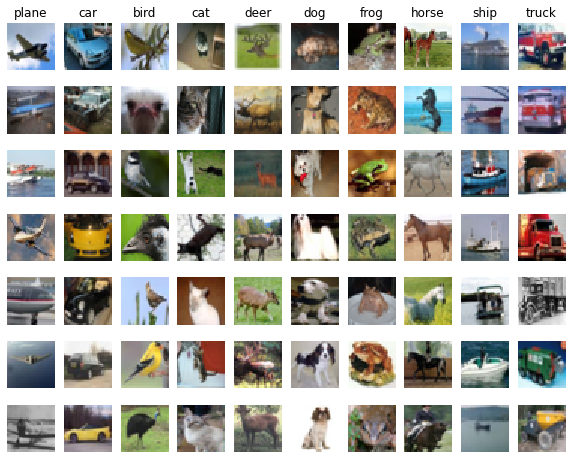

In [ ]:
# @title Visualize some examples from the dataset.
# We show a few examples of training images from each class.

# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-batches-py'

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Implement the softmax loss (cross-entropy loss)

In this tutorial, we will use a simple linear classifier



$$f\left(x_i, W, b\right)=W x_i+b$$

to optimize the Cross-entropy loss

$$H(p, q)=-\frac{1}{N}\sum_i L_i=-\frac{1}{N}\sum_i \log q\left(y_i \mid x_i ; W\right)$$

in which $q\left(y_i \mid x_i ; W\right)$ can be interpreted as the probability assigned to the correct label $y_i$ given the image $x_i$. This probability is obtained by the Softmax function
$$q\left(y_i \mid x_i ; W\right)=\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}.$$

We can extend the loss function with a regularization penalty
$$L=\underbrace{-\frac{1}{N} \sum_i L_i}_{\text {data loss }}+\underbrace{\lambda R(W)}_{\text {regularization loss }}.$$
The most common regularization penalty is the squared $L2$ norm that discourages large weights through an elementwise quadratic penalty over all parameters:
$$R(W)=\sum_k \sum_l W_{k, l}^2$$.

In [ ]:
f = np.array([123, 456, 789]) # example with 3 classes and each having large scores
p = np.exp(f) / np.sum(np.exp(f)) # Bad: Numeric problem, potential blowup
print("softmax: ", p) # Let's see what's wrong with this naive implementation

softmax:  [ 0.  0. nan]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


**Practical issues: Numeric stability**. When you’re writing code for computing the Softmax function in practice, the intermediate terms $e_{f_{y_i}}$ and $\sum_j e^{f_j}$ may be very large due to the exponentials. Dividing large numbers can be numerically unstable, so it is important to use a normalization trick. Notice that:

$$\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}=\frac{C e^{f_{y_i}}}{C \sum_j e^{f_j}}=\frac{e^{f_{y_i}+\log C}}{\sum_j e^{f_j+\log C}}$$

We are free to choose the value of $C$. A common choice for $C$ is to set $\log C=−max_j f_j$. This simply states that we should shift the values inside the vector f so that the highest value is zero.

In [ ]:
# first shift the values of f so that the highest number is 0:
f -= np.max(f) # f becomes [-666, -333, 0]
p = np.exp(f) / np.sum(np.exp(f)) # safe to do, gives the correct answer
print("stable softmax: ", p)

stable softmax:  [5.75274406e-290 2.39848787e-145 1.00000000e+000]


*Challenge: Why is $\log C=−max_j f_j$ a good choice for stablize Softmax function?*



Now, let's implement the Cross-entropy loss

The `softmax_loss` function computes the softmax loss and its gradient for a given set of weights \(W\), input data \(X\), labels \(y\), and regularization strength $\text{reg}\$.

The softmax function computes the probabilities of each class as:

$$ \text{probs}_{i,j} = \frac{\exp(\text{logits}_{i,j})}{\sum_{c=1}^{C} \exp(\text{logits}_{i,c})} $$

Where $\text{logits}$ are given by:

$$ \text{logits} = XW $$

For numerical stability, the logits are shifted by:

$$ \text{logits} -= \max(\text{logits}, \text{axis}=1) $$

The softmax loss is calculated using the negative log likelihood of the correct classes:

$$ \text{loss} = -\frac{1}{N} \sum_{i=1}^{N} \log(\text{probs}_{i, y_i}) $$

Regularization is added to this loss as:

$$ \text{loss} += \text{reg} \times \sum_{i=1}^{D} \sum_{j=1}^{C} W_{i,j}^2 $$

Where $\text{reg}$ is the regularization strength and $W$ are the weights.

Finally, the gradient with respect to the weights $W$ is:

$$ dW = \frac{X^T \text{probs}}{N} $$

With the regularization term:

$$ dW += 2 \times \text{reg} \times W $$


In [ ]:
# First implement the cross entropy loss in the below softmax_loss function.
# Then run this cell for testing.

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.373916
sanity check: 2.302585


In [ ]:
def softmax_loss(W, X, y, reg):
    """
    Compute the softmax loss and its gradient.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) Regularization strength.

    Returns:
    - loss: (float) Softmax loss for this batch of training samples.
    - dW: A numpy array of shape (D, C) containing the gradient of the loss with respect to W.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    num_train, dim = X.shape
    num_class = W.shape[1]

    #############softmax_loss################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. Don't forget the           #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

## Training with Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside the below LinearClassifier class.

In [ ]:
class LinearClassifier(object):
    def __init__(self):
        self.W = None

    def train(
        self,
        X,
        y,
        learning_rate=1e-3,
        reg=1e-5,
        num_iters=100,
        batch_size=200,
        verbose=False,
    ):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = (
            np.max(y) + 1
        )  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss(self.W, X_batch, y_batch, reg)

In [ ]:
# In the class LinearClassifier, implement SGD in the function
# train() and then run it with the code below.

import time

softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1000: loss 761.347661
iteration 100 / 1000: loss 279.505754
iteration 200 / 1000: loss 103.593245
iteration 300 / 1000: loss 39.260994
iteration 400 / 1000: loss 15.650513
iteration 500 / 1000: loss 7.052193
iteration 600 / 1000: loss 3.829681
iteration 700 / 1000: loss 2.775400
iteration 800 / 1000: loss 2.364945
iteration 900 / 1000: loss 2.192887
That took 24.040450s


In [ ]:
# Complete the predict() function and evaluate the performance
# on both the training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329673
validation accuracy: 0.349000


## Hyperparameters search

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 766.687755
iteration 100 / 1000: loss 281.288199
iteration 200 / 1000: loss 104.196844
iteration 300 / 1000: loss 39.440437
iteration 400 / 1000: loss 15.752549
iteration 500 / 1000: loss 7.102624
iteration 600 / 1000: loss 3.861067
iteration 700 / 1000: loss 2.703275
iteration 800 / 1000: loss 2.266194
iteration 900 / 1000: loss 2.170458
iteration 0 / 1000: loss 1536.656214
iteration 100 / 1000: loss 206.946478
iteration 200 / 1000: loss 29.493384
iteration 300 / 1000: loss 5.780089
iteration 400 / 1000: loss 2.656437
iteration 500 / 1000: loss 2.190707
iteration 600 / 1000: loss 2.155939
iteration 700 / 1000: loss 2.156081
iteration 800 / 1000: loss 2.161305
iteration 900 / 1000: loss 2.162306
iteration 0 / 1000: loss 768.220766
iteration 100 / 1000: loss 6.847984
iteration 200 / 1000: loss 2.164905
iteration 300 / 1000: loss 2.164255
iteration 400 / 1000: loss 2.082619
iteration 500 / 1000: loss 2.046319
iteration 600 / 1000: loss 2.094085
iteration 700 / 10

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.335000


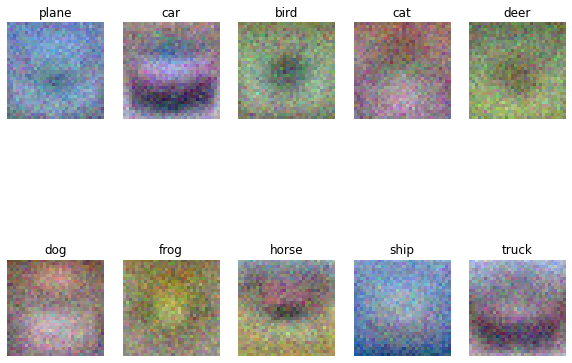

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])